<a href="https://colab.research.google.com/github/oodlbee/drug_prediction/blob/antons_branch/drug_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 20.4 MB/s eta 0:00:00


In [115]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [142]:
df_sheet_1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/hackatonsss/data_drug/1400.xlsx', sheet_name='Smile-IC50-CC50')
df_sheet_2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/hackatonsss/data_drug/1400.xlsx', sheet_name='Structures-ADMET')

In [143]:
df_sheet_1.head(1)

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0


In [144]:
df_sheet_2.head(1)

,molecule,Pictures,SMILES,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,#stars,#amine,#amidine,#acid,...,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,Unnamed: 55,Unnamed: 56
0,1007-Ya-213,50.0,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2.7,500.0,185.185185,2.0,0.0,0.0,0.0,...,35.245,2.0,0.0,0.0,0.0,0.0,0.0,14.0,NaN,NaN


## Предобработка данных

In [145]:
df_sheet_1.shape

(1468, 10)

In [146]:
df_sheet_1.head(1)

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0


In [147]:
backup = df_sheet_1.copy()
backup = backup.drop_duplicates(subset='SMILES')
backup.shape

(1380, 10)

In [148]:
backup.drop_duplicates(subset='Title').shape

(1380, 10)

In [149]:
backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1380 entries, 0 to 1467
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    1380 non-null   object 
 1   IC50, mmg/ml             1380 non-null   float64
 2   CC50-MDCK, mmg/ml        1380 non-null   float64
 3   SI                       1365 non-null   float64
 4   Molecular weight         1380 non-null   float64
 5   Hydrogen bond acceptors  1380 non-null   int64  
 6   Hydrogen bond donors     1380 non-null   int64  
 7   Polar SA                 1380 non-null   float64
 8   SMILES                   1380 non-null   object 
 9   Pictures                 659 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 118.6+ KB


In [152]:
backup = backup.drop(columns=['Pictures'])

In [153]:
backup['SI'] = backup['CC50-MDCK, mmg/ml']/backup['IC50, mmg/ml']

In [154]:
backup.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA
count,1380.000000,1380.000000,1.380000e+03,1380.000000,1380.000000,1380.000000,1380.000000
mean,49.148197,181.077657,2.350606e+04,389.593741,3.926087,1.384058,83.681239
std,88.454940,1039.746492,4.920820e+05,153.678839,2.896381,1.841124,54.327477
min,0.000010,0.031928,3.616134e-02,110.157000,0.000000,0.000000,0.000000
25%,2.500000,30.000000,1.830000e+00,290.366500,2.000000,0.000000,41.482500
50%,10.100000,86.600000,5.351471e+00,352.481000,3.000000,1.000000,73.660000
75%,49.450000,300.000000,2.500000e+01,447.874000,5.000000,2.000000,106.670000
max,1000.000000,37646.000000,1.632222e+07,1159.380000,19.000000,11.000000,319.510000


In [164]:
backup[backup['IC50, mmg/ml'] > 500]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES
682,863-MO-65-6,510.3,500.0,0.979816,364.443,6,2,77.38,C1C=C(C)[C@H](O)[C@@H]([C@H]12)O[C@H](C[C@@]2(...
688,869-TX-2214,1000.0,1000.0,1.000000,242.217,4,1,144.90,CCSc(n1)nn(c12)c(=O)c([N+]([O-])=O)n[nH]2


In [157]:
backup[backup['CC50-MDCK, mmg/ml'] > 500].shape

(17, 9)

In [166]:
backup = backup.drop(backup[backup['IC50, mmg/ml'] > 500].index)
backup = backup.drop(backup[backup['CC50-MDCK, mmg/ml'] > 500].index)

In [167]:
backup[backup['IC50, mmg/ml'] < 0]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES


In [168]:
backup[backup['CC50-MDCK, mmg/ml'] < 0]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES


In [169]:
backup.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA
count,1362.000000,1362.000000,1.362000e+03,1362.000000,1362.000000,1362.000000,1362.000000
mean,48.477909,137.254234,2.352211e+04,386.790830,3.873715,1.344347,82.785492
std,84.145592,132.121141,4.952266e+05,147.732533,2.790542,1.765766,53.216995
min,0.000010,0.031928,3.616134e-02,110.157000,0.000000,0.000000,0.000000
25%,2.500000,29.400000,1.810301e+00,290.363500,2.000000,0.000000,41.460000
50%,10.100000,83.300000,5.241425e+00,352.453000,3.000000,1.000000,73.610000
75%,49.550000,300.000000,2.421418e+01,446.741250,5.000000,2.000000,106.630000
max,500.000000,500.000000,1.632222e+07,1159.380000,19.000000,11.000000,319.510000


In [170]:
backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 0 to 1462
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    1362 non-null   object 
 1   IC50, mmg/ml             1362 non-null   float64
 2   CC50-MDCK, mmg/ml        1362 non-null   float64
 3   SI                       1362 non-null   float64
 4   Molecular weight         1362 non-null   float64
 5   Hydrogen bond acceptors  1362 non-null   int64  
 6   Hydrogen bond donors     1362 non-null   int64  
 7   Polar SA                 1362 non-null   float64
 8   SMILES                   1362 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 106.4+ KB


In [171]:
df_sheet_1 = backup

In [172]:
df_sheet_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 0 to 1462
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    1362 non-null   object 
 1   IC50, mmg/ml             1362 non-null   float64
 2   CC50-MDCK, mmg/ml        1362 non-null   float64
 3   SI                       1362 non-null   float64
 4   Molecular weight         1362 non-null   float64
 5   Hydrogen bond acceptors  1362 non-null   int64  
 6   Hydrogen bond donors     1362 non-null   int64  
 7   Polar SA                 1362 non-null   float64
 8   SMILES                   1362 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 106.4+ KB


In [173]:
df_sheet_2.head(1)

,molecule,Pictures,SMILES,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,#stars,#amine,#amidine,#acid,...,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,Unnamed: 55,Unnamed: 56
0,1007-Ya-213,50.0,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2.7,500.0,185.185185,2.0,0.0,0.0,0.0,...,35.245,2.0,0.0,0.0,0.0,0.0,0.0,14.0,NaN,NaN


In [174]:
df_sheet_2.shape

(1468, 57)

In [175]:
df_sheet_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   molecule                    1468 non-null   object 
 1   Pictures                    727 non-null    float64
 2   SMILES                      1468 non-null   object 
 3   IC50, mmg/ml                1468 non-null   float64
 4   CC50-MDCK, mmg/ml           1468 non-null   float64
 5   SI                          1444 non-null   float64
 6   #stars                      1417 non-null   float64
 7   #amine                      1417 non-null   float64
 8   #amidine                    1417 non-null   float64
 9   #acid                       1417 non-null   float64
 10  #amide                      1417 non-null   float64
 11  #rotor                      1417 non-null   float64
 12  #rtvFG                      1417 non-null   float64
 13  CNS                         1417 

In [176]:
backup = df_sheet_2.copy()

In [177]:
backup = backup[backup.molecule.isin(df_sheet_1.Title)]

In [178]:
backup.shape

(1365, 57)

In [179]:
backup['SI'] = backup['CC50-MDCK, mmg/ml']/backup['IC50, mmg/ml']

In [180]:
backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1462
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   molecule                    1365 non-null   object 
 1   Pictures                    657 non-null    float64
 2   SMILES                      1365 non-null   object 
 3   IC50, mmg/ml                1365 non-null   float64
 4   CC50-MDCK, mmg/ml           1365 non-null   float64
 5   SI                          1365 non-null   float64
 6   #stars                      1327 non-null   float64
 7   #amine                      1327 non-null   float64
 8   #amidine                    1327 non-null   float64
 9   #acid                       1327 non-null   float64
 10  #amide                      1327 non-null   float64
 11  #rotor                      1327 non-null   float64
 12  #rtvFG                      1327 non-null   float64
 13  CNS                         1327 

In [122]:
backup = backup.drop(columns=['Unnamed: 55', 'Unnamed: 56', 'Pictures'])

In [132]:
backup.corr()

<ipython-input-132-bf48fbb5467b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  backup.corr()


,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,...,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm
"IC50, mmg/ml",1.000000,0.049824,-0.026642,-0.108920,-0.097558,-0.087866,-0.082710,-0.049362,-0.182143,-0.091607,...,0.124855,-0.290972,0.352155,0.319349,-0.157445,-0.048819,-0.057681,-0.036966,-0.024150,-0.132112
"CC50-MDCK, mmg/ml",0.049824,1.000000,0.022387,-0.003743,-0.028012,-0.019934,0.084189,0.051673,0.020211,-0.014030,...,0.013807,0.007428,0.025472,0.018139,-0.014216,-0.012289,-0.014416,-0.007386,0.010712,0.003244
SI,-0.026642,0.022387,1.000000,-0.010100,-0.009793,0.024238,0.104375,0.009726,-0.009580,-0.023047,...,-0.006782,0.074977,-0.029794,-0.039175,0.024556,-0.012871,-0.009972,-0.009699,-0.035589,-0.008599
#stars,-0.108920,-0.003743,-0.010100,1.000000,-0.017933,0.003872,0.258572,0.175494,0.679065,0.402627,...,-0.018241,0.478203,-0.105590,0.097928,0.625620,0.264583,-0.018124,0.268882,0.405547,0.655355
#amine,-0.097558,-0.028012,-0.009793,-0.017933,1.000000,-0.060137,0.013324,0.197985,0.058569,-0.030409,...,0.033862,-0.051212,-0.005197,0.046702,-0.037664,-0.019341,0.111092,-0.025859,0.102502,0.015837
#amidine,-0.087866,-0.019934,0.024238,0.003872,-0.060137,1.000000,0.221295,0.245511,0.114939,-0.026355,...,0.054583,0.217662,-0.104725,-0.080658,0.030271,-0.155639,0.014442,-0.148911,0.015068,-0.018037
#acid,-0.082710,0.084189,0.104375,0.258572,0.013324,0.221295,1.000000,0.259746,0.320463,-0.015189,...,0.018701,0.422683,0.001801,0.039719,0.332975,0.073626,-0.059107,0.086353,-0.018307,0.309432
#amide,-0.049362,0.051673,0.009726,0.175494,0.197985,0.245511,0.259746,1.000000,0.268030,0.055194,...,0.212474,0.335693,-0.043137,-0.017005,0.164258,0.025914,-0.010400,0.035700,0.187688,0.263533
#rotor,-0.182143,0.020211,-0.009580,0.679065,0.058569,0.114939,0.320463,0.268030,1.000000,0.333389,...,-0.028014,0.497930,-0.067136,0.101341,0.586482,0.002976,-0.116181,0.029043,0.064835,0.614271
#rtvFG,-0.091607,-0.014030,-0.023047,0.402627,-0.030409,-0.026355,-0.015189,0.055194,0.333389,1.000000,...,0.025944,0.306073,0.095289,0.197394,0.350688,0.322304,0.133517,0.316822,0.319338,0.490600


<ipython-input-129-d285dbebf57d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(backup.corr(), cmap="YlGnBu", annot=False)


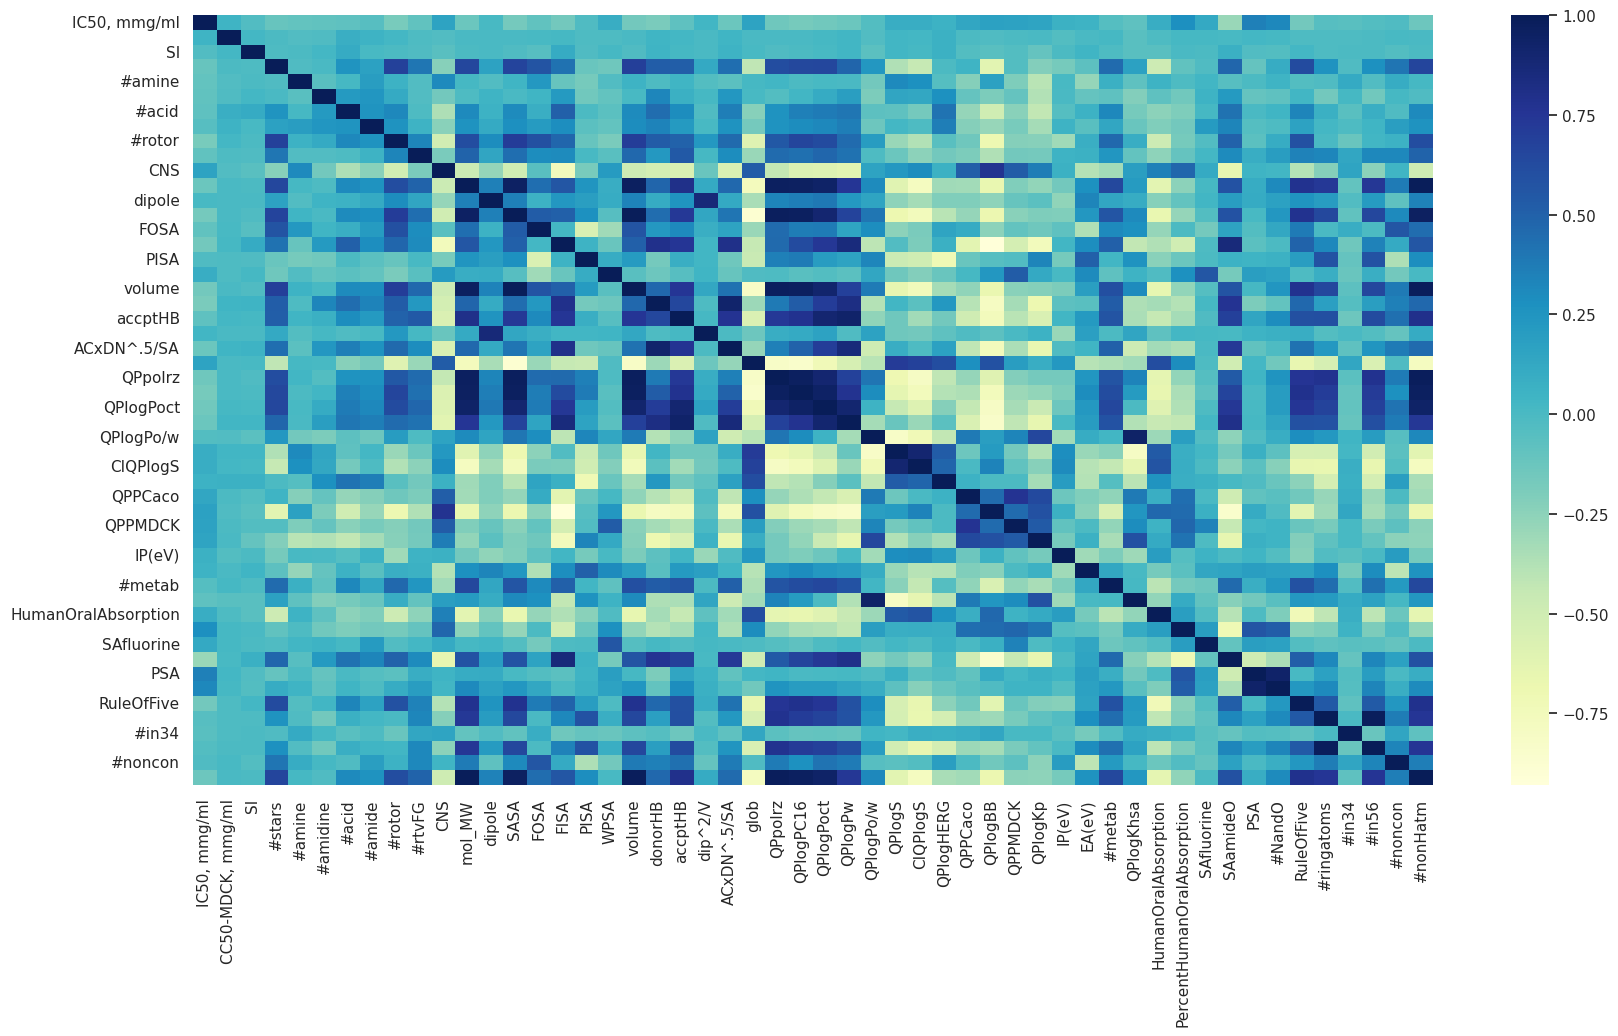

In [129]:
sns.set(rc={'figure.figsize':(20, 10)})
dataplot = sns.heatmap(backup.corr(), cmap="YlGnBu", annot=False)

plt.show()

## Анализ данных

In [62]:
df_1400.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures
count,1468.000000,1468.000000,1.444000e+03,1468.000000,1468.000000,1468.000000,1468.000000,727.000000
mean,50.277063,186.491530,2.217641e+04,384.739636,3.831744,1.333787,81.273215,364.909216
std,92.184768,1009.454293,4.726006e+05,153.164268,2.860473,1.803663,54.078778,210.154325
min,0.000010,0.031928,0.000000e+00,110.157000,0.000000,0.000000,0.000000,1.000000
25%,2.500000,30.375000,1.885549e+00,283.049250,2.000000,0.000000,39.440000,183.500000
50%,10.100000,90.400000,5.600000e+00,349.371000,3.000000,1.000000,71.840000,365.000000
75%,49.450000,300.000000,2.832642e+01,446.508000,5.000000,2.000000,106.160000,546.500000
max,1000.000000,37646.000000,1.596170e+07,1159.380000,19.000000,11.000000,319.510000,728.000000


In [63]:
df_1400.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    1468 non-null   object 
 1   IC50, mmg/ml             1468 non-null   float64
 2   CC50-MDCK, mmg/ml        1468 non-null   float64
 3   SI                       1444 non-null   float64
 4   Molecular weight         1468 non-null   float64
 5   Hydrogen bond acceptors  1468 non-null   int64  
 6   Hydrogen bond donors     1468 non-null   int64  
 7   Polar SA                 1468 non-null   float64
 8   SMILES                   1468 non-null   object 
 9   Pictures                 727 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 114.8+ KB


In [64]:
df_1400.shape

(1468, 10)

In [65]:
df_1400['SI'] = df_1400['CC50-MDCK, mmg/ml']/df_1400['IC50, mmg/ml']
df_1400['S_leng'] = df_1400['SMILES'].str.len()

<Axes: xlabel='Hydrogen bond donors', ylabel='Count'>

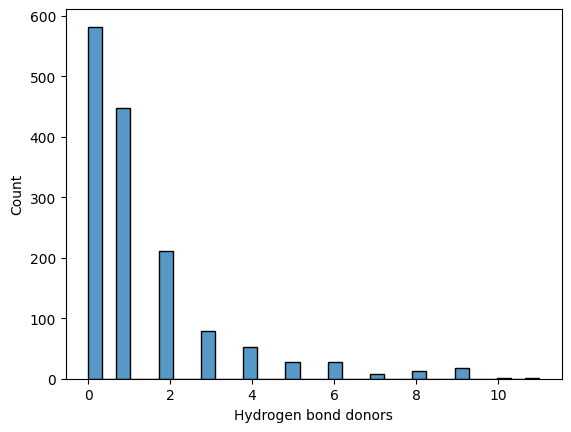

In [66]:
sns.histplot(df_1400['Hydrogen bond donors'])

<Axes: xlabel='Hydrogen bond acceptors', ylabel='Count'>

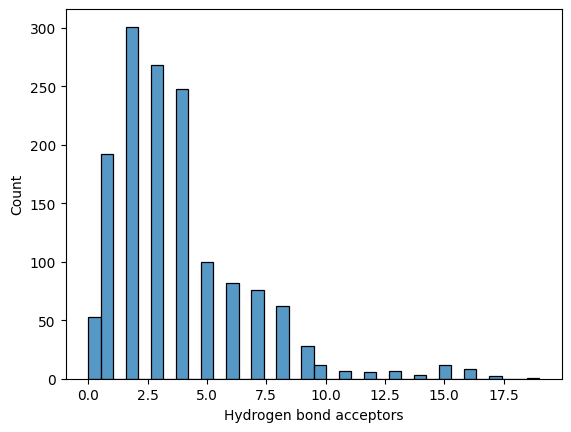

In [67]:
sns.histplot(df_1400['Hydrogen bond acceptors'])

<Axes: xlabel='Molecular weight', ylabel='Count'>

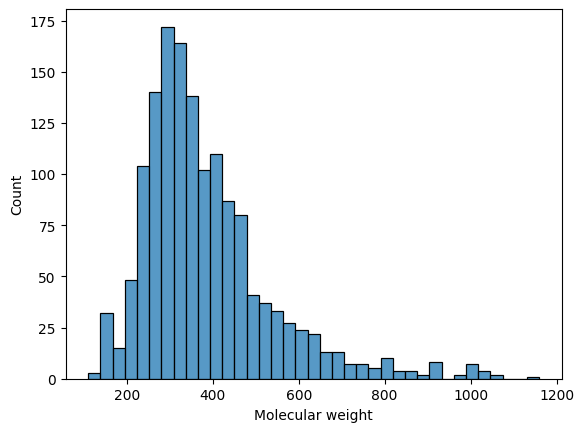

In [68]:
sns.histplot(df_1400['Molecular weight'])

<Axes: xlabel='S_leng', ylabel='Count'>

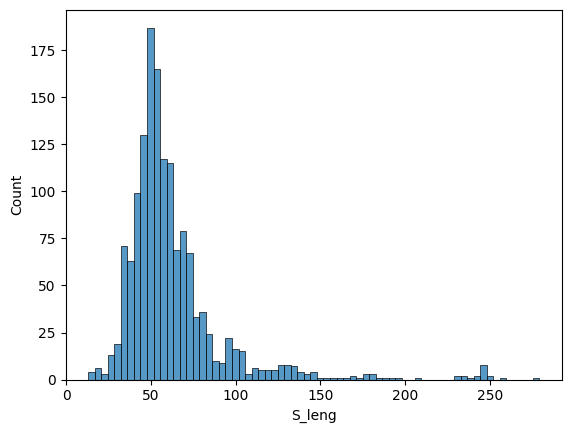

In [69]:
sns.histplot(df_1400['S_leng'])

<Axes: xlabel='IC50, mmg/ml', ylabel='Count'>

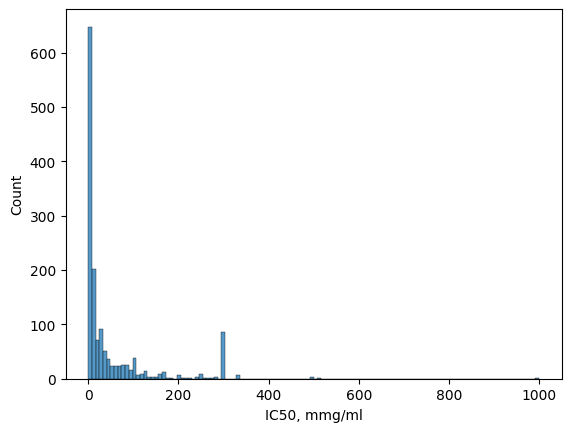

In [70]:
sns.histplot(df_1400['IC50, mmg/ml'])

In [71]:
df_1400.corr()

<ipython-input-71-cde5b6d3e7a0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_1400.corr()


,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,Pictures,S_leng
"IC50, mmg/ml",1.000000,0.054449,-0.025285,-0.124947,-0.070279,-0.137051,-0.076304,0.135774,-0.110493
"CC50-MDCK, mmg/ml",0.054449,1.000000,0.022211,-0.000079,-0.009657,0.013175,0.016038,-0.033486,0.011527
SI,-0.025285,0.022211,1.000000,-0.007332,0.011587,0.016661,0.051047,-0.108787,-0.006196
Molecular weight,-0.124947,-0.000079,-0.007332,1.000000,0.713369,0.534786,0.738870,0.148361,0.881565
Hydrogen bond acceptors,-0.070279,-0.009657,0.011587,0.713369,1.000000,0.646138,0.812043,0.060206,0.682413
Hydrogen bond donors,-0.137051,0.013175,0.016661,0.534786,0.646138,1.000000,0.752662,-0.028040,0.622681
Polar SA,-0.076304,0.016038,0.051047,0.738870,0.812043,0.752662,1.000000,0.244553,0.673769
Pictures,0.135774,-0.033486,-0.108787,0.148361,0.060206,-0.028040,0.244553,1.000000,0.012710
S_leng,-0.110493,0.011527,-0.006196,0.881565,0.682413,0.622681,0.673769,0.012710,1.000000


In [36]:
df = df_1400[['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'S_leng', 'SMILES']]

# df = df[df['IC50, mmg/ml'] < 200]
df = df[df['S_leng'] < 140]

In [37]:
df.head()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng,SMILES
0,2.7,500.0,185.185185,195.307,2,1,32.59,35,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2
1,0.7,447.0,638.571429,195.307,2,1,32.59,35,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2
2,9.9,144.0,14.545455,250.431,1,0,15.60,41,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2
3,8.3,500.0,60.240964,222.377,1,0,15.60,39,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2
4,39.4,143.0,3.629442,239.361,2,0,29.54,44,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C


In [38]:
df.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
count,1422.000000,1422.000000,1.398000e+03,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000
mean,51.570343,184.890834,2.286346e+04,368.340238,3.570323,1.163150,76.846266,58.606892
std,93.355782,1023.758510,4.803024e+05,122.898747,2.408416,1.492215,47.887539,20.217488
min,0.000010,0.031928,0.000000e+00,110.157000,0.000000,0.000000,0.000000,13.000000
25%,2.525000,30.325000,1.833333e+00,281.368000,2.000000,0.000000,39.440000,46.000000
50%,10.600000,90.400000,5.412037e+00,345.262500,3.000000,1.000000,69.650000,54.000000
75%,52.150000,300.000000,2.770833e+01,433.513250,5.000000,2.000000,102.087500,67.000000
max,1000.000000,37646.000000,1.596170e+07,812.925000,17.000000,11.000000,296.980000,139.000000


In [39]:
df.shape, df_1400.shape

((1422, 9), (1468, 11))

## Предобработка